# 2. Photometric redshifts of galaxies

## 1b) 
The early work on photometric redshifts was done using linear regression. Design a regression estimator using either ridge, LASSO or linear regression to predict photometric redshifts, make sure to justify all the choises you make. Use the whole of file A for training and aim to obtain E($\theta$) < 0.01 as training error

In [18]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io.votable import parse_single_table
from astroML.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
import seaborn as sns
import pandas as pd

%matplotlib inline

In [7]:
# Read the document

#root = "/home/esmee/Documents/DBDM/DDM2017-master/FinalProject/"
root = "/disks/strw9/stoop/DBDM/DDM2017-master/FinalProject/Final-Project-DBDM/"
tableA = parse_single_table(root + "PhotoZFileA.vot")

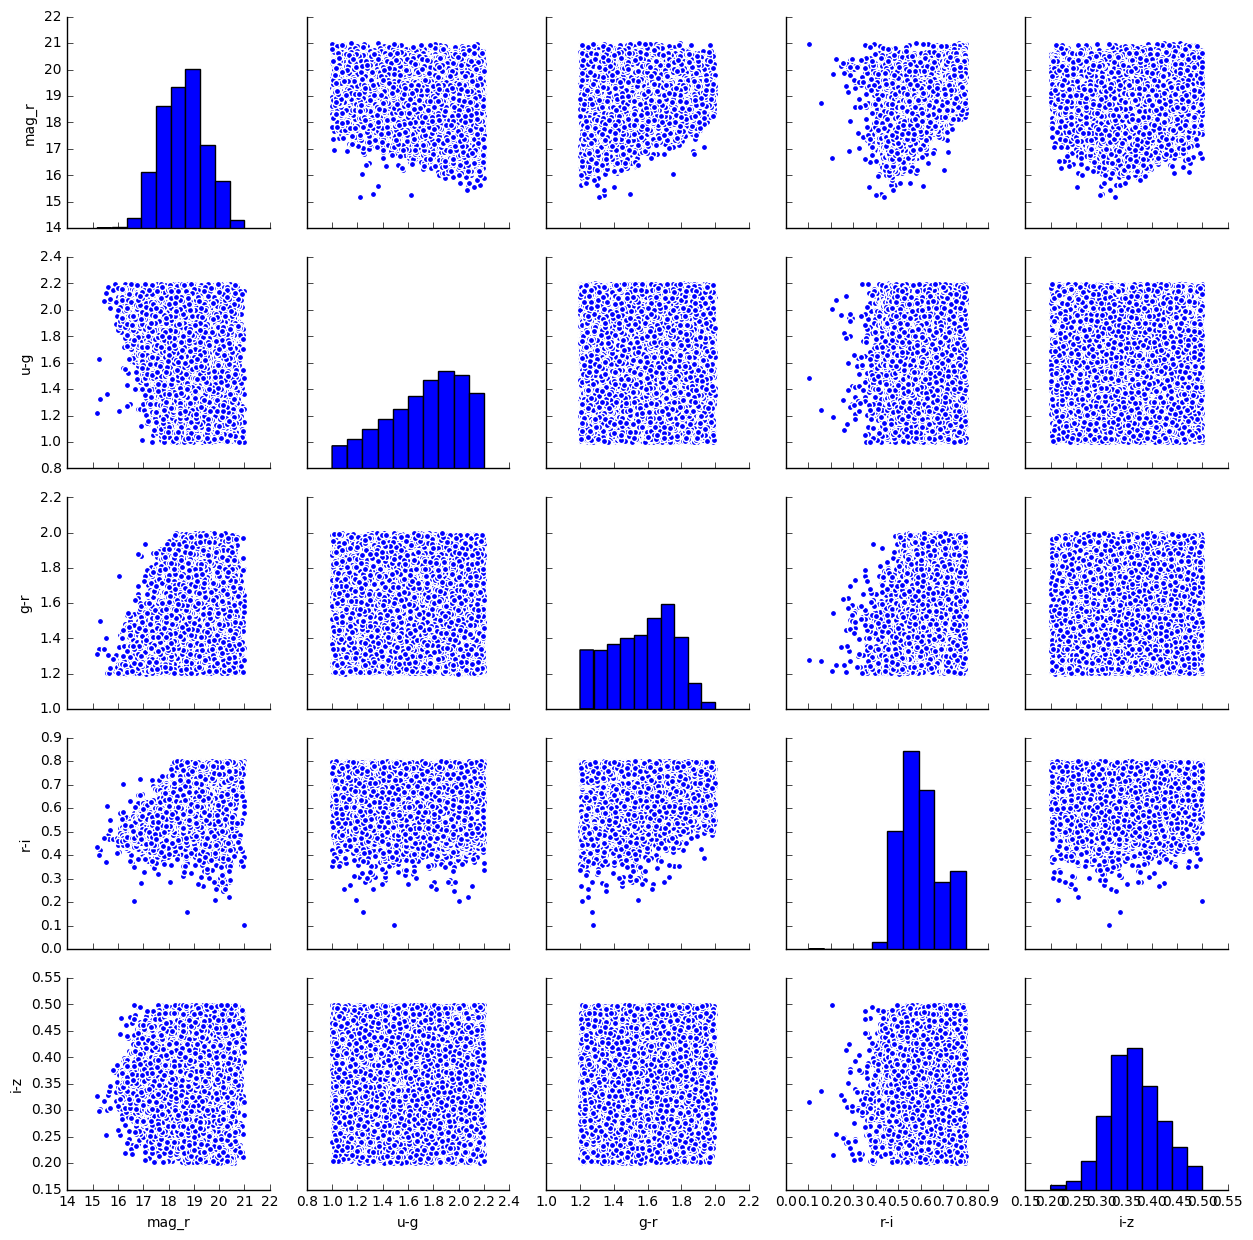

In [99]:
colnames = ['mag_r', 'u-g', 'g-r', 'r-i', 'i-z']
'''
fig, ax = plt.subplots(6,6,figsize=(12, 8))

for i, c1 in enumerate(colnames):
    for j,c2 in enumerate(colnames):
        ax[i,j].scatter(tableA.array[c1], tableA.array[c2], s=0.3, c='blue')'''

g = sns.pairplot(pd.DataFrame(Xa, columns=colnames))

In [87]:
Xa = np.vstack((tableA.array['mag_r'], tableA.array['u-g'], tableA.array['g-r'], tableA.array['r-i'], tableA.array['i-z'])).T
ya = tableA.array['z_spec']

def predict( X, y, model = 'Linear'):
    if model == 'Linear':
        model = LinearRegression(fit_intercept=True)
    if model == 'Ridge':
        model = Ridge(alpha=0.05,fit_intercept=True, normalize=True)
    if model == 'Lasso':
        model = Lasso(alpha=0.05,fit_intercept=True, normalize=True)
    
    res = model.fit(X, y)
    pred = res.predict(X)
    
    return res, pred


def E(y_pred, y):
    err = np.median(np.abs( (y-y_pred) / (1+y)))
    print "Found error: {0:.4f}".format(err)
    return err

In [89]:
# Predict and find the discrepancy 

print "\nLinear Regression:"
res1, pred1 = predict(Xa,ya, model='Linear')
print "Z = {0:.3f} + {1:.3f}$(mag_r) + {2:.3f}(u-g) + {3:.3f}(g-r) + {4:.3f}(r-i) + {5:.3f}(i-z)".format(res1.coef_[0],res1.coef_[1], res1.coef_[2], res1.coef_[3], res1.coef_[4], res1.coef_[5])    
e1 = E(pred1, ya)

print "\nLasso:"
res2, pred2 = predict(Xa,ya, model='Lasso')
c2 = [res2.intercept_]
[c2.append(coeff) for coeff in res2.coef_]
print "Z = {0:.3f} + {1:.3f}$(mag_r) + {2:.3f}(u-g) + {3:.3f}(g-r) + {4:.3f}(r-i) + {5:.3f}(i-z)".format(c2[0],c2[1], c2[2], c2[3], c2[4], c2[5])
e2 = E(pred2, ya)

print "\nRidge:"
res3, pred3 = predict(Xa,ya, model='Ridge')
c3 = [res3.intercept_]
[c3.append(coeff) for coeff in res3.coef_]
print "Z = {0:.3f} + {1:.3f}$(mag_r) + {2:.3f}(u-g) + {3:.3f}(g-r) + {4:.3f}(r-i) + {5:.3f}(i-z)".format(c3[0],c3[1], c3[2], c3[3], c3[4], c3[5])
e3 = E(pred3, ya)


Linear Regression:
Z = -0.783 + 0.040$(mag_r) + -0.013(u-g) + 0.083(g-r) + 0.416(r-i) + 0.021(i-z)
Found error: 0.0146

Lasso:
Z = 0.323 + 0.000$(mag_r) + -0.000(u-g) + 0.000(g-r) + 0.000(r-i) + 0.000(i-z)
Found error: 0.0503

Ridge:
Z = -0.756 + 0.039$(mag_r) + -0.014(u-g) + 0.084(g-r) + 0.399(r-i) + 0.031(i-z)
Found error: 0.0146


## 1c) 
Use file B to quantify the generalisation error of the estimator you derived in problem b.

In [90]:
# Read the document of table B

tableB = parse_single_table(root + "PhotoZFileB.vot")
Xb = np.vstack((tableB.array['mag_r'], tableB.array['u-g'], tableB.array['g-r'], tableB.array['r-i'], tableB.array['i-z'])).T
yb = tableB.array['z_spec']

In [92]:
# Predict the test data

print "Test set"
er_test = E(res1.predict(Xb), yb)

Test set
Found error: 0.0146


## 1d)
Implement a photo-z estimator using the method of your choice from any of the regression methods
discussed in the course, excluding the linear regression methods, e.g. k-nearest neighbours,
random forests, neural networks, boosting methods, but aim to get a lower generalisation error
than your method derived in problem b.

<Container object of 5 artists>

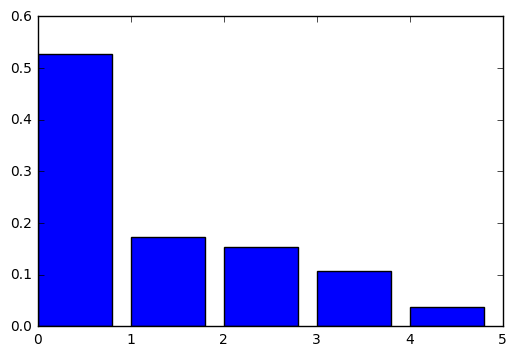

In [100]:
#Check which are the principal components

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=5, whiten=True)
scl = StandardScaler()
Xs = scl.fit_transform(X)
pca.fit(Xs)

xtmp = np.arange(len(pca.explained_variance_))
ytmp = pca.explained_variance_ratio_
        
plt.bar(xtmp, ytmp)